# Práctica 4 - AG frases en castellano con mutaciones y elitismo - Lab 2
## Preparación de entorno
#### Instalar las librerías

In [9]:
# %pip install numpy
# %pip install matplotlib
# %pip install pandas

#### Importar librerías de código

In [10]:
import math
import random
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Algoritmo genético SetUp

En los algoritmos genéticos, el elitismo es una estrategia que podemos utilizar para asegurarnos de que los mejores individuos, es decir, las soluciones más cercanas al objetivo, nunca se pierdan de una generación a otra. Normalmente, al acabar una genereación, todos los individuos pueden ser modificados, reemplazados o mutados. Esto lo que significa es que, por azar, incluso las mejores soluciones que hemos encontrado hasta el momento podrían desaparacer. Para evitarlo, introducimos el elitismo: una técnica que preserva automáticamente uno o varios de los individuos con mejor rendimeinto, copiándolos directamente a la siguiente generación sin modificarlos.

Como el objetivo del elitismo es garantizar que lo que ya se ha aprendido no se pierda por culpa de las mutaciones o reemplazos ayuda a que converja más ápido hacia una buena solución, ya que siempre parte de los mejores resultados. En resumen, actúa como una especie de "memoria" dentro del proceso evolutivo, asegurando que las mejores soluciones se mantengan presentes mientras se sigue explorando el resto del espacio de posibilidades.

In [11]:
class AlgoritmoGenetico:
    # Cada gen puede tener ser cualquier letra del alfabeto (A-Z) o un espacio
    GENES = list("ABCDEFGHIJKLMNÑOPQRSTUVWXYZ ")

    def __init__(self, target, NPOB, NGEN, Pm, NRES, NSAMPLE):
        self.target = target
        self.NPOB = NPOB
        self.NGEN = NGEN
        self.Pm = Pm
        self.NRES = NRES
        self.NSAMPLE = NSAMPLE
        self.longitud_target = len(target)

    def crear_individuo(self, ltar: int) -> str:
        """
        Crea un individuo (un string) de longitud ltar
        con letras aleatorias.

        Args:
            ltar (int): Longitud de la frase objetivo.

        Returns:
            str: Individuo aleatorio.
        """
        # Básicamente, mientras estemos dentro el rango de la longitud
        # de la frase objetivo, elegimos un gen (letra o espacio) al azar
        # y lo añadimos a la cadena de caracteres.
        cadena_resultado = ""

        for _ in range(ltar):
            gen = random.choice(self.GENES)
            cadena_resultado += gen

        return cadena_resultado

    def calcular_fitness(self, individuo: str) -> tuple:
        """
        Calcula el fitness (parecido) de un individuo
        con respecto a la frase objetivo. El fitness se calcula
        como la diferencia entre el número de coincidencias
        y la longitud de la frase objetivo.

        Args:
            individuo (str): Individuo a evaluar.

        Returns:
            tuple: (fitness, ncoin)
                * fitness: valor entre 0 y (casi) 1 que mide lo bien que se parece el individuo al target.
                * ncoin (int): Número de coincidencias con la frase objetivo.
        """
        # Número de coincidencias entre el
        # individuo y la frase objetivo
        ncoin = 0

        # Para cada caracter en el individuo comprobamos
        # si coincide con el caracter de la frase objetivo
        for caracter in range(len(individuo)):
            if individuo[caracter] == self.target[caracter]:
                ncoin += 1

        # Número de caracteres de la frase objetivo
        longitud_tar = self.longitud_target

        # Calculamos el fitness (parecido) entre el individuo y la frase objetivo
        fitness = math.exp(ncoin - longitud_tar) - math.exp(-longitud_tar)

        return fitness, ncoin

    def mutar_gen(self, gen: str) -> str:
        """
        Decide si un gen debe mutar en función de la probabilidad Pm.

        Si el gen muta, elegimos un nuevo al azar de la lista de genes.
        Si no muta, devolvemos el gen original.

        Args:
            gen (str): Carácter del individuo (Mayúscula o espacio).

        Returns:
            str: Nuevo gen (puede estar mutado o no).
        """

        # Elegimos una probabilidad al azar entre 0 y 1.
        # Si la probabilidad es menor que Pm, el gen muta.
        # Si no, devolvemos el gen original.
        probabilidad = random.random()

        if (probabilidad < Pm):
            # Elegimos un nuevo gen al azar de la lista de genes
            # y lo devolvemos.
            return random.choice(self.GENES)
        else:
            # Devolvemos el gen original.
            return gen

    def mutar_individuo(self, padre):
        """
        Aplica una mutuación a cada gen de un individuo.

        Recorre todos los genes (caracteres) del individuo padre y, para cada uno,
        decide si debe mutar utilizando la función `mutar_gen`.

        Args:
            padre (str): String original

        Returns:
            str: Nuevo individuo tras aplicar las mutaciones.
        """
        # Creamos un string vacío para el individuo mutado
        individuo_mutado = ""

        # Recorremos cada gen del individuo padre y aplicamos la mutación
        for gen in padre:
            individuo_mutado += self.mutar_gen(gen)

        return individuo_mutado

    def obtener_consenso(self, poblacion):
        """
        Calcula el individuo consenso de una población.

        El individuo consenso es un string que contiene el
        carácter más frecuente en cada posición de la población.

        Args:
            poblacion (list): Lista de individuos (strings).

        Returns:
            str: Cadena de consenso construida con los caracteres más
            frecuentes en cada posición.
        """
        # Inicializamos el string para el individuo consenso
        # y recorremos cada posición de la población
        consenso = ""

        # Como todos los individuos tienen la misma longitud, podemos
        # usar la longitud del primer individuo como referencia
        # para recorrer la población.
        for posicion in range(len(poblacion[0])):

            # Cogemos la letra de cada inviduo en la posición actual
            letras = [individuo[posicion] for individuo in poblacion]

            # Contamos cuantas veces aparace cada letra y nos quedamos
            # con la letra que más veces aparece y la añadimos al consenso.
            # Counter(letras) -> Contamos las letras
            # (1) -> Seleccionamos la letra más común -> [tupla(letra, frecuencia)]
            # [0] -> Seleccionamos la tupla -> tupla(letra, frecuencia)
            # [0] -> Seleccionamos la letra de la tupla -> letra
            consenso += Counter(letras).most_common(1)[0][0]

        return consenso

    def ejecutar(self, porcentaje_elite=0.25):
        """
        Algoritmo genético modificado que selecciona un porcentaje fijo de los mejores individuos
        en cada generación, y genera hijos a partir de ellos hasta reconstituir toda la población.

        Args:
            porcentaje_elite (float): Proporción de los mejores individuos que se seleccionan como padres (0 < valor < 1).
                                      Por defecto, 0.25 (25%).

        Returns:
            tuple: (poblacion, ncoin_max, mejor_individuo)
                * poblacion (list): Población final tras todas las generaciones.
                * ncoin_max (int): Número máximo de coincidencias del mejor individuo.
                * mejor_individuo (str): Mejor individuo encontrado en la última generación.
        """
        poblacion = [self.crear_individuo(self.longitud_target) for _ in range(self.NPOB)]
        print(f"TARGET: {self.target}, ltar: {self.longitud_target}, NPOB: {self.NPOB}, NGEN: {self.NGEN}, Pm: {self.Pm}")

        for generacion in range(self.NGEN):
            # Calcular fitness de todos los individuos
            fitnesses = [(ind, *self.calcular_fitness(ind)) for ind in poblacion]
            fitnesses.sort(key=lambda x: x[1], reverse=True)

            # Selección de élite
            num_elite = max(1, int(self.NPOB * porcentaje_elite))
            elite = fitnesses[:num_elite]

            # Cada padre genera el número necesario de hijos para reconstruir NPOB
            hijos_por_padre = self.NPOB // num_elite
            nueva_poblacion = []

            for ind, _, _ in elite:
                for _ in range(hijos_por_padre):
                    hijo = self.mutar_individuo(ind)
                    nueva_poblacion.append(hijo)

            # Asegurar que la población se mantiene en tamaño NPOB
            poblacion = nueva_poblacion[:self.NPOB]

            if generacion % self.NRES == 0 or generacion % self.NSAMPLE == 0:
                lista_num_coincidencias = [sum(1 for a, b in zip(ind, self.target) if a == b) for ind in poblacion]
                ncoin_max = max(lista_num_coincidencias)
                ncoin_media = np.mean(lista_num_coincidencias)
                NTar = lista_num_coincidencias.count(self.longitud_target)
                pNTar = 100 * (NTar / self.NPOB)
                consenso = self.obtener_consenso(poblacion)

                print(f"\nGeneración nº{generacion}: Mejor individuo con {ncoin_max} coincidencias, NTar = {NTar} ({pNTar:.2f}%)")
                print(f"Consenso: {consenso}, Coincidencias medias: {ncoin_media:.2f}")

                if generacion % self.NSAMPLE == 0:
                    muestra = random.sample(poblacion, max(1, int(self.NPOB * 0.2)))
                    print("\n Muestra de la población:")
                    for individuo in muestra:
                        print(f" * {individuo}")

        mejor_individuo = max(poblacion, key=lambda ind: sum(1 for a, b in zip(ind, self.target) if a == b))
        ncoin_mejor = sum(1 for a, b in zip(mejor_individuo, self.target) if a == b)
        return poblacion, ncoin_mejor, mejor_individuo

    def comparar_elitismos(self, elitismos):
        """
        Ejecuta el algoritmo genético para distintos porcentajes de elitismo y compara los resultados.

        Prueba el rendimiento del algoritmo genético variando el porcentaje de elitismo
        (proporción de mejores individuos seleccionados como padres) y evalúa cuál porcentaje obtiene
        mejores resultados en términos de coincidencias con la frase objetivo.

        Args:
            elitismos (list of float): Lista de valores de porcentaje de elitismo a probar (valores entre 0 y 1).

        Returns:
            pandas.DataFrame: Tabla comparativa con las columnas:
                * "Elitismo (%)": Valor del porcentaje de elitismo expresado en porcentaje.
                * "Coincidencias": Número de coincidencias del mejor individuo con la frase objetivo.
                * "Mejor Individuo": Representación en texto del mejor individuo encontrado.
        """
        resultados = []

        for porcentaje in elitismos:
            _, ncoin, mejor_individuo = self.ejecutar(porcentaje_elite=porcentaje)
            resultados.append({
                "Elitismo (%)": round(porcentaje * 100),
                "Coincidencias": ncoin,
                "Mejor Individuo": mejor_individuo
            })

        df = pd.DataFrame(resultados).sort_values(by="Coincidencias", ascending=False)

        return df


# Parámetros del problema
target = "DARTH VADER"     # Frase objetivo
NPOB = 100                 # Número de individuos en la población
NGEN = 300                 # Número de generaciones a ejecutar
Pm = 0.1                   # Probabilidad de mutación
NRES = 20                  # Frecuencia de resumen (cada NRES generaciones)
NSAMPLE = 50               # Frecuencia de muestreo (cada NSAMPLE generaciones)

elitismos = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]

# Crear instancia del algoritmo
ag = AlgoritmoGenetico(target, NPOB, NGEN, Pm, NRES, NSAMPLE)

# Ejecutar comparación de elitismos
df_resultados = ag.comparar_elitismos(elitismos)

# Mostrar resultados
display(df_resultados)

# Mostrar mejor porcentaje
mejor_porcentaje = df_resultados.iloc[0]["Elitismo (%)"]
print(f"\nEl mejor porcentaje de elitismo es: {mejor_porcentaje}%")

TARGET: DARTH VADER, ltar: 11, NPOB: 100, NGEN: 300, Pm: 0.1

Generación nº0: Mejor individuo con 3 coincidencias, NTar = 0 (0.00%)
Consenso: ÑAQUPPVPIEO, Coincidencias medias: 1.72

 Muestra de la población:
 * ÑPEAXPFOHRL
 * UQJMD  WIEO
 * ÑAWB QUPREL
 * NLQUPRVGUEL
 * BDUZPKVLDXO
 * VABB QUPXEL
 * VAWB QUPZEL
 * GWEAXPFOHRR
 * BDUZPKVVDYO
 * NGQUPOVGUEL
 * YHNMD DWIEO
 * VAWB QGPREL
 * BDUZPK VDXC
 * ÑPEAXPFOHRR
 * BDUZTKVVDXO
 * NGQUPOVGUEL
 * TGQUPOVGUEL
 * BDUZPKVPDXO
 * UHNMD  WIEO
 * BDUZPKVVDXO

Generación nº20: Mejor individuo con 10 coincidencias, NTar = 0 (0.00%)
Consenso: DARTW VADER, Coincidencias medias: 8.98

Generación nº40: Mejor individuo con 11 coincidencias, NTar = 26 (26.00%)
Consenso: DARTH VADER, Coincidencias medias: 9.87

Generación nº50: Mejor individuo con 11 coincidencias, NTar = 37 (37.00%)
Consenso: DARTH VADER, Coincidencias medias: 10.04

 Muestra de la población:
 * DARTH VADEX
 * DARTH VAAER
 * DARQH VADER
 * DARTE VADER
 * DARTH VADER
 * DARTH VADER


,Elitismo (%),Coincidencias,Mejor Individuo
0,5,11,DARTH VADER
1,10,11,DARTH VADER
2,20,11,DARTH VADER
3,25,11,DARTH VADER
4,30,11,DARTH VADER
5,40,8,DARTU QAGER
6,50,8,DARTH ZUDNR



El mejor porcentaje de elitismo es: 5%


Al igual que en la práctica anterior, vamos a llevar a cabo es un experimento para analizar cómo se comporta nuestro algoritmo en funciones con ciertas parámetros: la longitud de la frase objetivo, el tamaño de la población y el número de generación. Para hacer esto vamos a utilizar frases y palabras con longitudes que van desde 5 hasta 25 caracteres. El objetivo de este experimiento es comprobar cómo influyen los parámetros en la capacidad de nuestro algoritmo para encontrar exactamente la frase que queremos.

Ejecutando experimento: ltar=5, NPOB=50, NGEN=250
TARGET: DOOKU, ltar: 5, NPOB: 50, NGEN: 250, Pm: 0.1

Generación nº0: Mejor individuo con 2 coincidencias, NTar = 0 (0.00%)
Consenso: GOIZU, Coincidencias medias: 0.60

 Muestra de la población:
 * VOIZE
 * NÑAEB
 * PHURZ
 * XMOBX
 * VOOZE
 * GFRHU
 * ZZSTU
 * NÑAFB
 * NÑAEB
 *  OQGC
Ejecutando experimento: ltar=5, NPOB=50, NGEN=500
TARGET: DOOKU, ltar: 5, NPOB: 50, NGEN: 500, Pm: 0.1

Generación nº0: Mejor individuo con 1 coincidencias, NTar = 0 (0.00%)
Consenso: CHMXU, Coincidencias medias: 0.65

 Muestra de la población:
 * XSGXU
 * CNMXX
 * KH LU
 * GNXJU
 * JOIJT
 * HSCKB
 * WHMKC
 * FNXJU
 * COHXP
 * COHXP
Ejecutando experimento: ltar=5, NPOB=50, NGEN=1000
TARGET: DOOKU, ltar: 5, NPOB: 50, NGEN: 1000, Pm: 0.1

Generación nº0: Mejor individuo con 1 coincidencias, NTar = 0 (0.00%)
Consenso: VAZÑM, Coincidencias medias: 0.25

 Muestra de la población:
 * AQWÑE
 * BBBPP
 *  AÑKK
 * KOFCZ
 * XKPMC
 *  AÑKÑ
 * ZVQZP
 * KOFXZ
 * XNQZP
 *

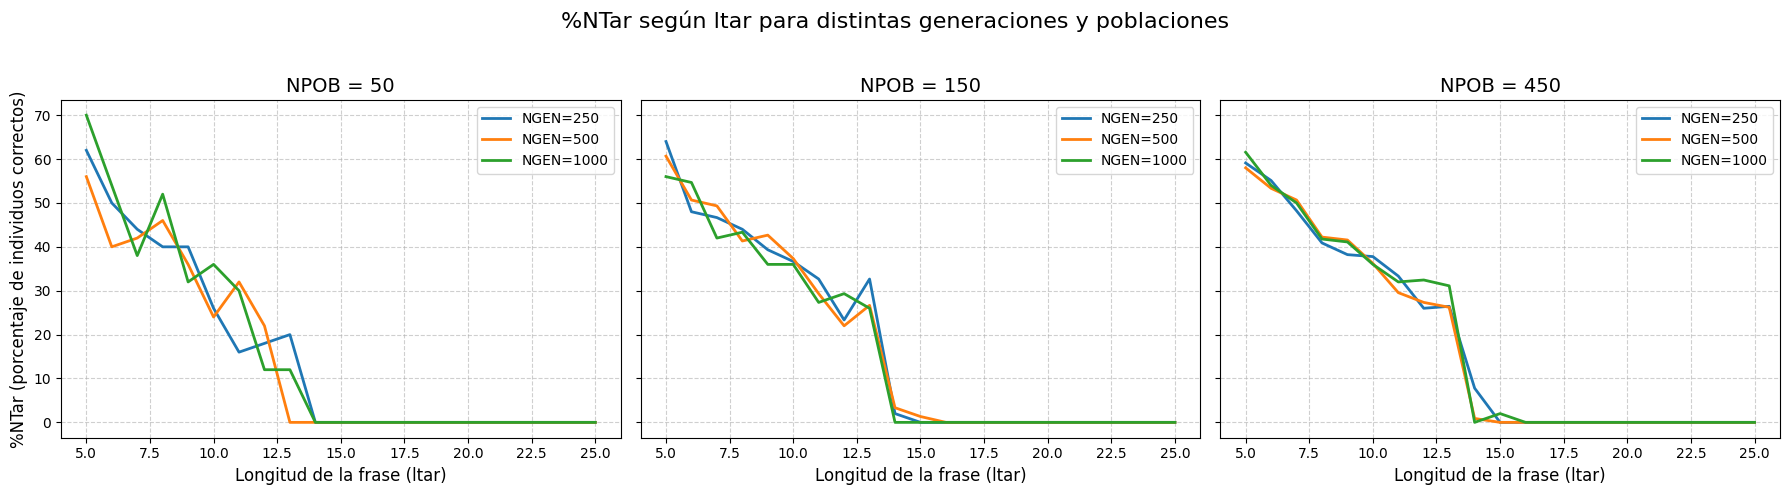

In [12]:
FRASES_OBJETIVO = [
    "Dooku", # 5 letras
    "Greedo", # 6 letras
    "Obi Wan", # 7 letras
    "Grievous", # 8 letras
    "Skywalker", # 9 letras
    "Darth Maul", # 10 letras
    "Darth Vader", # 11 letras
    "Qui Gon Jinn", # 12 letras
    "Padme Amidala", # 13 letras
    "Return of Jedi", # 14 letras
    "Hello there Obi", # 15 letras
    "I am your father", # 16 letras
    "Power of the dark", # 17 letras
    "No I am the senate", # 18 letras
    "The force is strong", # 19 letras
    "The force is with us", # 20 letras
    "The dark side is real", # 21 letras
    "The force binds us all", # 22 letras
    "I am one with the Force", # 23 letras
    "Fear is the path to dark", # 24 letras
    "The Force is strong in us", # 25 letras
]

def ejecutar_experimento(target: str, NPOB: int, NGEN: int, Pm: float = 0.1) -> dict:
    """
    Ejecuta una prueba del algoritmo genético para una frase objetivo determinada y
    devuelve métricas de rendimiento de la población final.

    LLanza una ejecución completa del algoritmo genético con los parámetros
    especificados, y calcula al final de la evolución las principales métricas que
    describen el comportamiento de la población en relación con la frase objetivo.

    Parámetros:
        target (str): Frase objetivo que queremos alcanzar.
        NPOB (int): Número de individuos en la población.
        NGEN (int): Número de generaciones que ejecutaremos.
        Pm (float, opcional): Probabilidad de mutación por gen (por defecto 0.1).

    Retorna:
        dict: Un diccionario con las siguientes claves:
            * "ltar" (int): Longitud de la frase objetivo.
            * "NPOB" (int): Número de individuos en la población.
            * "NGEN" (int): Número de generaciones ejecutadas.
            * "ncoinmax" (int): Número máximo de coincidencias con la frase objetivo.
            * "ncoinmedio" (float): Número medio de coincidencias con la frase objetivo.
            * "NTar" (int): Número de individuos que coinciden completamente con la frase objetivo.
            * "%NTar" (float): Porcentaje de individuos que coinciden completamente con la frase objetivo.
    """

    ag = AlgoritmoGenetico(target, NPOB, NGEN, Pm, NRES=NGEN + 1, NSAMPLE=NGEN * 1)

    # Ejecutamos el algorito genético con los parámetros que pasan a la función
    poblacion_final, _, _ = ag.ejecutar()

    # Calculamos el número de coincidencias en la población final
    num_coincidencias = []

    for individuo in poblacion_final:
        coincidencias = sum(1 for a, b in zip(individuo, target) if a == b)
        num_coincidencias.append(coincidencias)

    # Calculamos el número máximo y medi de coincidencias
    num_concidencias_max = max(num_coincidencias)
    num_concidencias_medio = np.mean(num_coincidencias)

    # Calculamos el número de individuos que coinciden al 100% con la frase objetivo
    # y el porcentaje de coincidencias
    NTar = num_coincidencias.count(len(target))
    pNTar = 100 * NTar / NPOB

    return {
        "ltar": len(target),
        "NPOB": NPOB,
        "NGEN": NGEN,
        "ncoinmax": num_concidencias_max,
        "ncoinmedio": num_concidencias_medio,
        "NTar": NTar,
        "%NTar": pNTar
    }

# Definimos los parámetros para el experimento.
# Vamos a probar con poblaciones objetivo y con generaciones
generaciones_experimento = [250, 500, 1000]
poblaciones_experimento = [50, 150, 450]
resultados = []

# Para cade frase objetivo, vamos a ejectuar un experimento
# así podremos comprar los resultados en función de la longitud
# de la frase, el número de individuos y el número de generaciones
for frase_objetivo in FRASES_OBJETIVO:

    # Calculamos la longitud de la frase objetivo
    longitud_frase = len(frase_objetivo)

    # Ejecutamos el experimento para cada combinación de numero de individuos
    # y generaciones
    for NPOB in poblaciones_experimento:
        for NGEN in generaciones_experimento:
            print(f"Ejecutando experimento: ltar={longitud_frase}, NPOB={NPOB}, NGEN={NGEN}")
            resultado = ejecutar_experimento(frase_objetivo.upper(), NPOB, NGEN)
            resultados.append(resultado)

# Convertimos los resultados de todos los experimentos
# a un DataFrame
df = pd.DataFrame(resultados)

# Obtenemos los valores de NPOB para después porder
# hacer un subplot en función de ellos
valores_NPOB = sorted(df["NPOB"].unique())

# Creamos una figura con subplots: uno por cada NPOB
fig, axs = plt.subplots(1, len(valores_NPOB), figsize=(18, 5), sharey=True)

# Recorremos cada NPOB y dibujamos la evolución de %NTar
# en función de ltar en los experimentos
for indice, NPOB in enumerate(valores_NPOB):

    # Seleccionamos el subplot que corresponde a
    # el NPOB actual
    ax = axs[indice]

    # Cogemos solo las filas que tienen el NPOB
    # actual
    subset_NPOB = df[df["NPOB"] == NPOB]

    # Dibujamos una línea para cada valor de NGEN dentro de este NPOB
    for i, (NGEN, subset) in enumerate(subset_NPOB.groupby("NGEN")):
        # Ordenamos el subset por ltar para que la línea
        # se dibuje de forma ordenada (menor a mayor)
        subset_sorted = subset.sort_values("ltar")

        # Dibujamos la línea para este NGEN
        ax.plot(subset_sorted["ltar"], subset_sorted["%NTar"], label=f"NGEN={NGEN}", linewidth=2)

    ax.set_title(f"NPOB = {NPOB}", fontsize=14)
    ax.set_xlabel("Longitud de la frase (ltar)", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)
    if indice == 0:
        ax.set_ylabel("%NTar (porcentaje de individuos correctos)", fontsize=12)
    ax.legend(fontsize=10)

plt.suptitle("%NTar según ltar para distintas generaciones y poblaciones", fontsize=16)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

En este último apartado vamos analizar otra vez cómo influye la probabilidad de mutación ($P_m$) en el rendimiento del nuestro algoritmo genético para la frase `"ANIMULA VAGULA BLANDULA"` (tiene 23 letras). Para hacerlo, vamos a hacer varias ejecuciones del algoritmo, manteniendo el número de individuos y de generaciones y variando el valor $P_m$ entre $0.01$ y $0.5$. 

En cada ejecución, vamos a guardar las métricas del final de la evolución (el porcentaje y el número de individuos que son exactamente la frase objetivo, el número máximo de caracteres coincidentes con la frase, la media de coincidencias en la población y el número de coincidencias del indiviuo consenso).

Probando Pm = 0.010...
TARGET: ANIMULA VAGULA BLANDULA, ltar: 23, NPOB: 300, NGEN: 1000, Pm: 0.01

Generación nº0: Mejor individuo con 5 coincidencias, NTar = 0 (0.00%)
Consenso: ALYRUYAWVAGVLW PLBNABTC, Coincidencias medias: 1.73

 Muestra de la población:
 * FTDOPHYHTA HVÑ ACÑLACTX
 * ALFMÑYSATOGJVXTHLRGT VÑ
 *  WUVVAINQQIUAWE DCGUFHN
 * GASZDYTEXA SHGK CVZVIPR
 * ZBWKKOBCXAPDREOVEPFACWN
 * NZBLDEPECZ QXNTYLJ MTKY
 * K YKZVMXBÑPATAÑVYBYCTMF
 * QJYLUYAIFFSNXORTEZVIRZG
 * MCBKQLRRISQVUWAIUOVYILN
 * ÑFBZYSXR  LXLZTBGIKOFÑJ
 * HAUB KPWVLGBGSUWXM KZWF
 * JSUERZN ZOCPKBÑSXNBCP F
 * BOZKUNZQVXMEGSGP XEROÑF
 * SUSRBXDWCAGUJAQXRGWHADB
 * KFYKZWMXBÑPATRÑHYBYCTMF
 * ÑFBSYIXR VLXLZTBGIKAFVU
 * AXFYHGVGLBGCQZQG NP JKO
 * OXYWFQCYTZRZYIHSLBLMETC
 * NUÑSTJJLROÑXLUGPLVRIBÑL
 * BHIFCXNZFFPSOV QRCRGJJF
 * ÑÑXRRLOZI XSXWAVLWXSBPT
 * SUSRBXDWCAGUJAQXRGWHPDB
 * WXEMFWZQLLDGRXVBNJPÑCRG
 * KPPM TNBB YNFNKJIGOUTZW
 * PBMEDSKOMQKCZÑVHJZGSWCU
 * EUFZUSF KGTASBCEYIZASZK
 * GBISGBWQBJÑVLUVBÑWJ EIR
 * NLISGBWQBJ

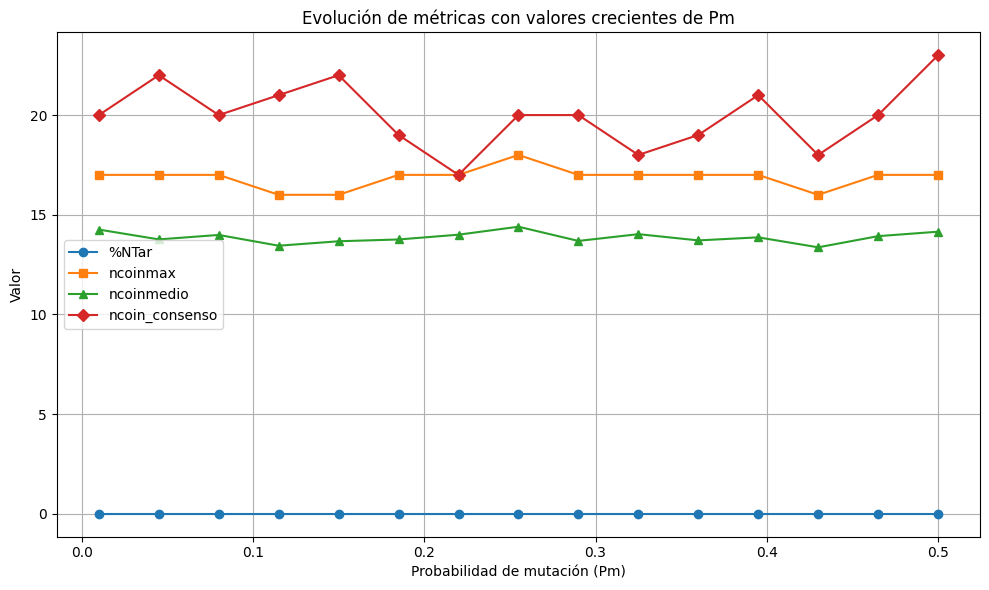

In [13]:
def experimento_vs_Pm(target: str, NPOB: int = 300, NGEN: int = 1000, valores_Pm=None):
    """
    Ejecuta un experimento para analizar el impacto de distintos valores de probabilidad
    de mutación (Pm) sobre el rendimiento del algoritmo genético con una frase objetivo fija.

    Para cada valor de Pm, ejecutamos el algoritmo con una población inicial aleatoria,
    un número fijo de generaciones (NGEN) y tamaño de población (NPOB). Al finalizar cada
    ejecución, calculamos el porcentaje y número de individuos que coinciden completamente
    con el objetivo, el número máximo y medio de coincidencias por individuo, y la calidad
    del individuo consenso.

    Parámetros:
        target (str): Frase objetivo que queremos alcanzar.
        NPOB (int, opcional): Número de individuos en la población. Por defecto 300.
        NGEN (int, opcional): Número de generaciones a ejecutar. Por defecto 1000.
        valores_Pm (list of float, opcional): Lista de valores de probabilidad de mutación a probar.
            Si no se especifica, se generan automáticamente 15 valores equiespaciados entre 0.01 y 0.5.

    Retorna:
        pandas.DataFrame: Un DataFrame con una fila por cada valor de Pm probado y las siguientes columnas:
            * "Pm": Valor de probabilidad de mutación utilizado.
            * "%NTar": Porcentaje de individuos que coinciden exactamente con el target.
            * "NTar": Número total de individuos perfectos.
            * "ncoinmax": Máximo número de caracteres coincidentes con el target.
            * "ncoinmedio": Media de coincidencias entre individuos y el target.
            * "consenso": Cadena de texto que representa el individuo consenso de la población.
            * "ncoin_consenso": Número de coincidencias del consenso con el target.
    """

    # Si no nos especifican valores de Pm, generamos 15 valores
    # equiespaciados entre 0.01 y 0.5
    if valores_Pm is None:
        valores_Pm = np.linspace(0.01, 0.5, 15)

    resultados = []

    for Pm in valores_Pm:
        print(f"Probando Pm = {Pm:.3f}...")

        # Creamos una instancia del algoritmo genético con el valor de Pm actual
        ag = AlgoritmoGenetico(target, NPOB, NGEN, Pm, NRES=NGEN-1, NSAMPLE=NGEN-1)

        # Ejecutamos el algoritmo genético
        poblacion_final, _, _ = ag.ejecutar()

        # Calculamos el número de coincidencias en la población final
        num_coincidencias = []
        for individuo in poblacion_final:
            coincidencias = sum(1 for a, b in zip(individuo, target) if a == b)
            num_coincidencias.append(coincidencias)

        # Calculamos el número máximo y medio de coincidencias
        num_concidencias_max = max(num_coincidencias)
        num_concidencias_medio = np.mean(num_coincidencias)

        # Calculamos el número de individuos que coinciden al 100% con la frase objetivo
        NTar = num_coincidencias.count(len(target))
        pNTar = 100 * NTar / NPOB

        # Calculamos el consenso de la población
        consenso = ag.obtener_consenso(poblacion_final)
        num_coincidencias_consenso = sum(1 for a, b in zip(consenso, target) if a == b)

        resultados.append({
            "Pm": Pm,
            "%NTar": pNTar,
            "NTar": NTar,
            "ncoinmax": num_concidencias_max,
            "ncoinmedio": num_concidencias_medio,
            "consenso": consenso,
            "ncoin_consenso": num_coincidencias_consenso
        })

    return pd.DataFrame(resultados)


# Ejecutamos el experimento con la frase objetivo
df_pm = experimento_vs_Pm("ANIMULA VAGULA BLANDULA", NPOB=300, NGEN=1000)

# Mostramos los resultados del experimento en una gráfica
plt.figure(figsize=(10, 6))
plt.plot(df_pm["Pm"], df_pm["%NTar"], marker='o', label="%NTar")
plt.plot(df_pm["Pm"], df_pm["ncoinmax"], marker='s', label="ncoinmax")
plt.plot(df_pm["Pm"], df_pm["ncoinmedio"], marker='^', label="ncoinmedio")
plt.plot(df_pm["Pm"], df_pm["ncoin_consenso"], marker='D', label="ncoin_consenso")

plt.xlabel("Probabilidad de mutación (Pm)")
plt.ylabel("Valor")
plt.title("Evolución de métricas con valores crecientes de Pm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()